## Pre-processing the chosen geotiffs before passing to the stratification notebook

Checklist:
- all incoming data using same projection (and if not, reproject)
- align the spatial resolutions
- data cleaning - check for missing values
- normalise/ scale pixel values
- create data cube

some resources to check later:
https://discourse.pangeo.io/t/advice-for-scalable-raster-vector-extraction/4129

Adopt the python Builder pattern or pipeline pattern here to ensure robust pre-processing

In [74]:
%pip install pydantic -q

Note: you may need to restart the kernel to use updated packages.


In [75]:
import os

import numpy as np
import xarray as xr
import geopandas as gpd

import matplotlib.pyplot as plt

import rasterio
from rasterio.warp import calculate_default_transform, reproject
from rasterio.enums import Resampling
import rioxarray
import rioxarray.merge

from rio_cogeo.cogeo import cog_translate
from rio_cogeo.profiles import cog_profiles

from pydantic import BaseModel, field_validator
from typing import List

import logging

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    handlers=[
                        logging.FileHandler("debug.log"),
                        logging.StreamHandler()
                    ])

In [76]:
class ResamplingMethods:
    NEAREST = "nearest"
    BILINEAR = "bilinear"
    CUBIC = "cubic"

In [77]:
def load_rasters(raster_dir):
    data_arrays = []
    for raster_file in os.listdir(raster_dir):
        if raster_file.endswith('.tiff') or raster_file.endswith('.tif'):
            raster_path = os.path.join(raster_dir, raster_file)
            # Open the raster file as an xarray DataArray with rioxarray
            data_array = rioxarray.open_rasterio(raster_path)
            data_arrays.append(data_array)
    return data_arrays

In [78]:
def get_filenames(input_raster_dir):
    filenames = []
    for raster_file in os.listdir(input_raster_dir):
        if raster_file.endswith('.tiff') or raster_file.endswith('.tif'):
            fpath = os.path.join(input_raster_dir, raster_file)
            fname = os.path.basename(fpath)
            filenames.append(fname)
    return filenames

In [97]:
def check_consistency(data_arrays, dst_crs):
    formatted_crs = f"EPSG:{dst_crs}"
    num_rasters = len(data_arrays)

    logging.info(f"Checking {num_rasters} raster data arrays for consistency before merging:")
    crs_set = {da.rio.crs for da in data_arrays if da.rio.crs is not None}
    if len(crs_set) > 1:
        logging.error("Inconsistent CRS found: {}".format(crs_set))
        logging.info("Attempting to convert all data arrays to the same data type.")
        return projection_check(data_arrays, formatted_crs)
    else:
        logging.info("All input rasters are in the same reference system (CRS)")
        

    


    if crs_set != {formatted_crs}:
        logging.info(f"Converting all data arrays to the target CRS: {formatted_crs}.")
        return projection_check(data_arrays, formatted_crs)
    else:
        logging.info("All data arrays are already in the target CRS.")

    # Check for missing values in any of the DataArrays
    missing_values_found = False
    for da in data_arrays:
        if da.isnull().any():
            logging.error("Missing values found in one of the data arrays")
            missing_values_found = True
            break
    if not missing_values_found:
        logging.info("No missing values found in any of the data arrays.")



In [80]:
def projection_check(data_arrays, target_crs):
    reprojected_data_arrays = []
    for da in data_arrays:
        if da.rio.crs != target_crs:
            # Reproject the data array to the target CRS
            reprojected_da = da.rio.reproject(target_crs)
            reprojected_data_arrays.append(reprojected_da)
        else:
            reprojected_data_arrays.append(da)
    return reprojected_data_arrays
        

In [81]:
def convert_dtypes(data_arrays):
    converted_data_arrays = []
    for da in data_arrays:
        original_nodata = da.rio.nodata
        input_da = da.astype("float32")
        # Replace original NoData with NaN in float32
        if original_nodata is not None:
            input_da = input_da.where(
                input_da != original_nodata, np.nan
            )
        
            input_da.rio.write_nodata(np.nan, inplace=True)
            converted_data_arrays.append(input_da)
    return converted_data_arrays

In [82]:
def set_nodata(data_arrays):
    nodata_set_arrays = []
    for da in data_arrays:
        original_nodata = da.rio.nodata
        input_da = da.astype("float32")
        # Replace original NoData with NaN in float32
        if original_nodata is not None:
            input_da = input_da.where(input_da != original_nodata, np.nan)
        
        input_da.rio.write_nodata(np.nan, inplace=True)
        input_da.rio.set_nodata(np.nan, inplace=True)
        nodata_set_arrays.append(input_da)
    return nodata_set_arrays

In [83]:
def find_finest_resolution(data_arrays) -> float:
    finest_x_res = float('inf')  # Start with a large number as the finest resolution
    finest_y_res = float('inf')

    for da in data_arrays:
            current_x_res = abs(da.rio.resolution()[0])
            current_y_res = abs(da.rio.resolution()[1])
            # Update the finest resolution if the current one is smaller
            if current_x_res < finest_x_res:
                finest_x_res = current_x_res
                finest_y_res = current_y_res
    return finest_x_res, finest_y_res

In [84]:
def find_finest_raster(data_arrays):
    # find the dataarray with the finest resolution and set that array as the one to match:
    finest_res = float('inf')
    finest_raster = None
    
    for da in data_arrays:
        current_res = abs(da.rio.resolution()[0])
        if current_res < finest_res:
            finest_res = current_res
            finest_raster = da
    return finest_raster

In [85]:
def resample_match(data_arrays):
    # because of small differences in coordinates dur to floating precision, also make sure to use assign_coords so all rasters have identical extents.
    finest_raster = find_finest_raster(data_arrays)
    resampled_data_arrays = []
    for da in data_arrays:
        if da is not finest_raster:
            # Resample the data array to match the resolution of the finest data array
            resampled_da = da.rio.reproject_match(finest_raster)
            resampled_da = resampled_da.assign_coords(x=finest_raster.x, y=finest_raster.y)
            resampled_da = resampled_da.rio.interpolate_na("linear")
            resampled_data_arrays.append(resampled_da)
        else:
            resampled_da = resampled_da.rio.interpolate_na("linear")
            resampled_data_arrays.append(da)
    return resampled_data_arrays

In [86]:
# def trim_empty_rows_cols(data_arrays):
#     rows_to_trim = 2
#     trimmed_data_arrays = []
#     for da in data_arrays:
#         y_coords = da.y.values
#         new_y_max = y_coords[-rows_to_trim - 1]
#         sliced_raster = da.rio.slice_xy(minx=da.x.min(), miny=da.y.min(), maxx=da.x.max(), maxy = new_y_max)
#         trimmed_data_arrays.append(sliced_raster)
        
#     return trimmed_data_arrays

In [87]:

def save_as_cog(data_arrays, filenames, output_dir):

    for data_array, filename in zip(data_arrays, filenames):
        new_filename = filename.replace('.tif', '_processed.tif')
        output_path = os.path.join(output_dir, new_filename)  # Construct the full output path
        # Save using rio-cogeo
        data_array.rio.to_raster(output_path, driver='COG')

In [88]:
target_crs = 3857

input_raster_dir = "/workspace/notebooks/sandbox/data/stratification/input-rasters"
output_raster_dir = "/workspace/notebooks/sandbox/data/stratification/processed-rasters"

input_rasters = load_rasters(input_raster_dir)
raster_filenames = get_filenames(input_raster_dir)

In [98]:
# check that the loaded rasters have the same CRS and dtype and there are no missing data:
checked_rasters = check_consistency(input_rasters, target_crs)


2024-06-25 02:23:46,017 - INFO - Checking 4 raster data arrays for consistency before merging:
2024-06-25 02:23:46,018 - INFO - All input rasters are in the same reference system (CRS)
2024-06-25 02:23:46,019 - INFO - Converting all data arrays to the target CRS: EPSG:3857.


In [90]:
checked_rasters = set_nodata(checked_rasters)

for da in checked_rasters:
    print(da.rio.nodata)


nan
nan
nan
nan


/usr/local/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(
/usr/local/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Selecting Resampling Method

- Nearest Neighbor: Fast and suitable for categorical data.
- Bilinear: Good for continuous data where interpolation between values can be meaningful.
- Cubic: Better for continuous data where a smoother output is desired.

In [91]:
#TODO: make sure there are non NaN pixels at edges after reasmpling, as they can't be passed to sklearn

resampled_data_arrays = resample_match(checked_rasters)



/usr/local/lib/python3.10/site-packages/rioxarray/raster_array.py:1011: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_xds in self._obj.groupby(extra_dim):


/usr/local/lib/python3.10/site-packages/rioxarray/raster_array.py:1011: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_xds in self._obj.groupby(extra_dim):
/usr/local/lib/python3.10/site-packages/rioxarray/raster_array.py:1011: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_xds in self._obj.groupby(extra_dim):


In [92]:
for da in resampled_data_arrays:
    print(f"Reprojected raster: \n----------\n")
    print(da.rio.shape)
    print(da.rio.resolution())
    print(da.rio.bounds())
    print(da.rio.crs)
    print("\n")


Reprojected raster: 
----------

(343, 438)
(32.41659920661789, -32.41659920661689)
(12942017.502979718, -3414826.23875225, 12956215.973432217, -3403707.3452243805)
EPSG:3857


Reprojected raster: 
----------

(343, 438)
(32.41659920661789, -32.41659920661689)
(12942017.502979718, -3414826.23875225, 12956215.973432217, -3403707.3452243805)
EPSG:3857


Reprojected raster: 
----------

(343, 438)
(32.41659920661789, -32.41659920661689)
(12942017.502979718, -3414826.23875225, 12956215.973432217, -3403707.3452243805)
EPSG:3857


Reprojected raster: 
----------

(343, 438)
(32.41659920661647, -32.41659920661647)
(12942017.502979718, -3414826.23875225, 12956215.973432217, -3403707.3452243805)
EPSG:3857




In [93]:
# resampled_data_arrays = trim_empty_rows_cols(resampled_data_arrays)

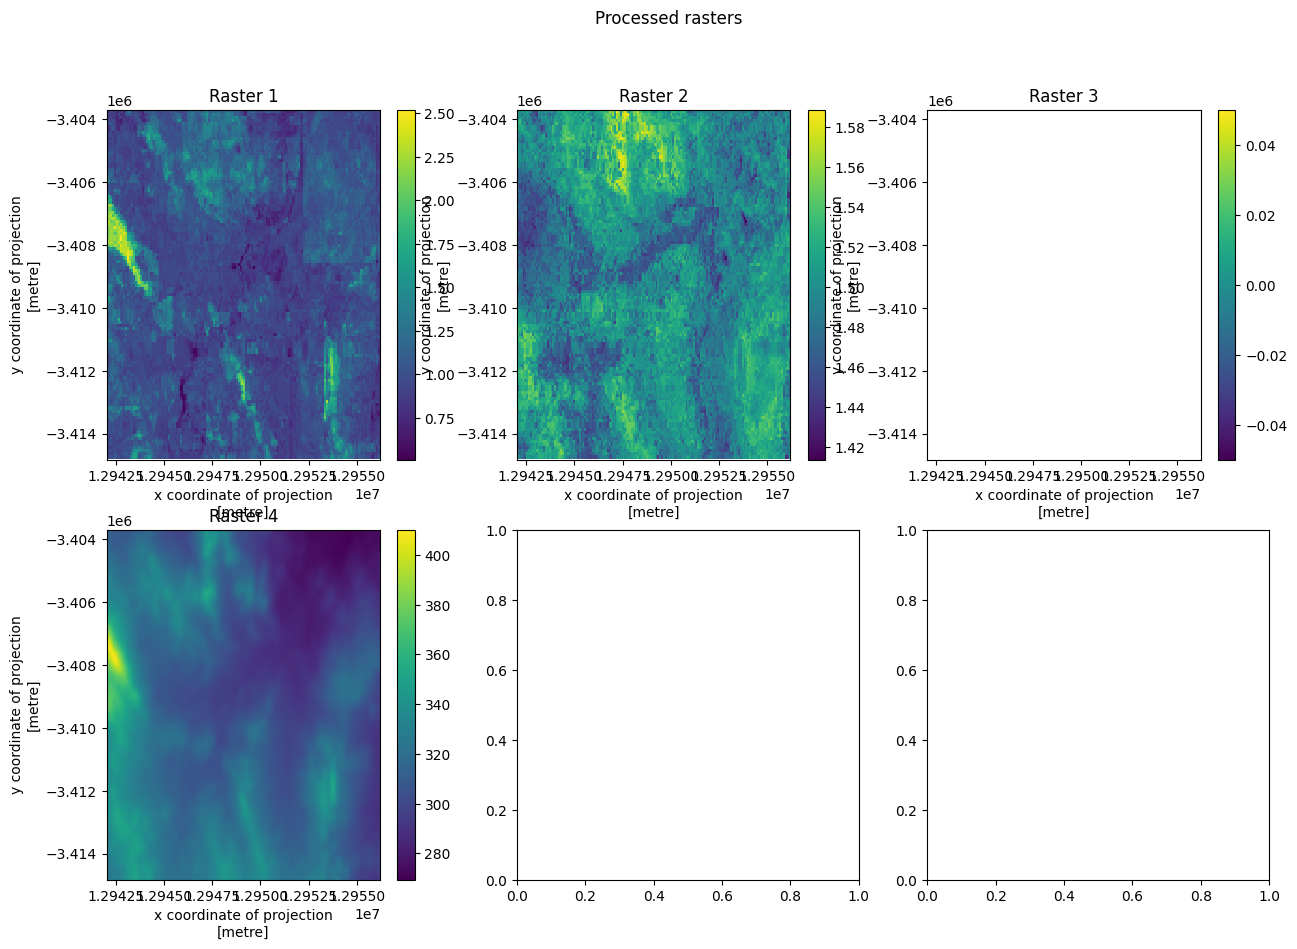

In [94]:
# this sets up a grid for plotting the rasters, irrespective of how mnay rasters are in the input list. Use this to check spatial extent of the processed rasters before using them in the stratification notebook.

n = len(resampled_data_arrays)
cols = 3
rows = (n + cols -1) // cols

fig, axs = plt.subplots(rows, cols, figsize = (5 * cols, 5 * rows))
fig.suptitle("Processed rasters")

axs = axs.flatten()

for i, raster in enumerate(resampled_data_arrays):
    raster.plot(ax = axs[i])
    axs[i].set_title(f"Raster {i+1}")

In [95]:
print(resampled_data_arrays[1])

<xarray.DataArray (band: 1, y: 343, x: 438)> Size: 1MB
array([[[1.50450087, 1.50450087, 1.50450087, ..., 1.48021519,
         1.48021519, 1.48021519],
        [1.50450087, 1.50450087, 1.50450087, ..., 1.48021519,
         1.48021519, 1.48021519],
        [1.50450087, 1.50450087, 1.50450087, ..., 1.48021519,
         1.48021519, 1.48021519],
        ...,
        [1.4966749 , 1.4966749 , 1.4966749 , ..., 1.51941967,
         1.51941967, 1.51941967],
        [1.4966749 , 1.4966749 , 1.4966749 , ..., 1.51941967,
         1.51941967, 1.51941967],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]])
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 4kB 1.294e+07 1.294e+07 ... 1.296e+07 1.296e+07
  * y            (y) float64 3kB -3.404e+06 -3.404e+06 ... -3.415e+06 -3.415e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0
    _FillValue:     nan


In [96]:
save_as_cog(resampled_data_arrays, raster_filenames, output_raster_dir)